In [98]:
import numpy as np

from sklearn.model_selection import train_test_split
from Pipeline.tf_dataset_builder import RawDatasetBuilder
from Pipeline.preprocess import BandpassFilter, Normalizer
from Pipeline.Cascade.Detection.optimization import GridSearch
from Pipeline.Cascade.Detection.detection_algorithms import HilbertDetector, MovingStdDetector, STALTADetector, ECODetector, ECDFOutlierCountDetector
from Pipeline.evaluation import detection_report
from Pipeline.tf_lite_utils import predict_tflite_mtl

In [4]:
seed = 1
np.random.seed(seed)

In [49]:
DatasetBuilder = RawDatasetBuilder(
    #dataset_dir='../../../Dataset/Generated dataset/Deployment/unstandardized/50ms/**/*.wav',
    dataset_dir="../../../Dataset/Final dataset/Generation/Generated dataset/**/*.wav",
    class_dict={'Background': 0, 'Big mandibles': 1, 'Small mandibles': 2},
    seed=seed,
)

features, labels = DatasetBuilder.get_features_and_labels()

In [50]:
bandpass = BandpassFilter(200, 20000, 44100, order=2)
features = [bandpass.filter(feature) for feature in features]

In [55]:
#remap labels to 0 and 1
def remap_labels(labels):
    return np.array([1 if label > 0 else 0 for label in labels])

labels = remap_labels(labels)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

# Incremental approach: detection stage

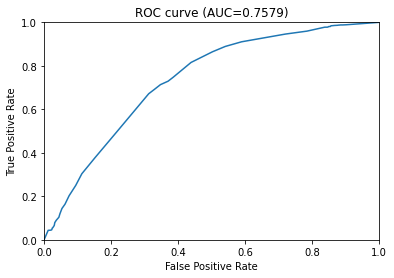

Best params: {'window_size': 50, 'grace_period': 30, 'factor': 0.0015}

Evaluation on the test set:
False alarm prob: 19.35%
Miss detection prob: 52.42%
Number of False Positives: 36
Number of False Negatives: 217
Detector f1-score is 60.896445%

Other Metrics:
Detector accuracy is 57.833333%
Detector precision is 84.549356%
Detector recall is 47.584541%


In [57]:
# Moving std detector (fixed)
params = {
    'window_size': [50],
    'grace_period': [30],
    'factor': [0.00023, 0.000235, 0.00024, 0.000245, 0.00025, 0.000255, 0.00026, 0.000265, 0.00027, 0.000275, 0.00028, 0.000285, 0.00029, 0.000295, 0.0003, 0.00035, 0.0004, 0.0005, 0.00055, 0.0006, 0.0007, 0.0008, 0.00085, 0.0009, 0.00095, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.0055, 0.006, 0.0065, 0.007,
      0.0075, 0.008, 0.0085, 0.009, 0.0095, 0.01]
    }

detector = MovingStdDetector(version='fixed')

optimizer = GridSearch(detector, params, X_train, y_train)

best_params = optimizer.optimize_roc(0.2, visual=True)

print(f'Best params: {best_params}')

detector.set_params(**best_params)
prediction = detector.detect(X_test)
detection_report(y_test, prediction)

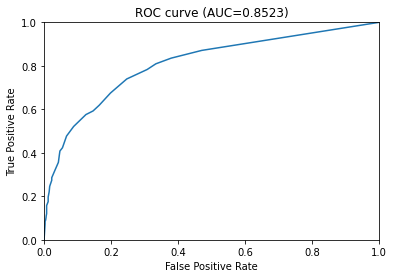

Best params: {'window_size': 500, 'grace_period': 30, 'factor': 5.75}

Evaluation on the test set:
False alarm prob: 14.52%
Miss detection prob: 34.78%
Number of False Positives: 27
Number of False Negatives: 144
Detector f1-score is 75.949367%

Other Metrics:
Detector accuracy is 71.500000%
Detector precision is 90.909091%
Detector recall is 65.217391%


In [142]:
# Moving std detector (adaptive)
params = {
    'window_size': [500],
    'grace_period': [30],
    'factor': [4.75, 5, 5.15, 5.25, 5.5, 5.75, 6, 6.15, 6.25, 6.5, 6.75, 7, 7.15, 7.25, 7.5, 7.75, 8.15, 8.25, 8.5, 8.75, 9, 9.15, 9.25, 9.5, 9.75, 10, 10.15, 10.25, 10.5, 10.75, 11]
}

detector = MovingStdDetector(version='adaptive')

optimizer = GridSearch(detector, params, X_train, y_train)

best_params = optimizer.optimize_roc(0.2, visual=True)

print(f'Best params: {best_params}')

detector.set_params(**best_params)
prediction = detector.detect(X_test)
detection_report(y_test, prediction)

In [ ]:
# Hilbert detector
params = {'factor': [6, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9, 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10, 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11, 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12]}

detector = HilbertDetector()

optimizer = GridSearch(detector, params, X_train, y_train)

best_params = optimizer.optimize_roc(0.2, visual=True)

print(f'Best params: {best_params}')

detector.set_params(**best_params)
prediction = detector.detect(X_test)
detection_report(y_test, prediction)

In [61]:
# STA/LTA Detector
params = {'sta_win': [100, 120, 140, 160, 180],
          'lta_win': [400, 420, 440, 460, 480, 500],
          'threshold': [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]}

detector = STALTADetector()

optimizer = GridSearch(detector, params, X_train, y_train)

best_params = optimizer.optimize_roc(0.2, visual=False)

print(f'Best params: {best_params}')

detector.set_params(**best_params)
prediction = detector.detect(X_test)
detection_report(y_test, prediction)

Best params: {'sta_win': 180, 'lta_win': 440, 'threshold': 0.7}

Evaluation on the test set:
False alarm prob: 18.82%
Miss detection prob: 57.25%
Number of False Positives: 35
Number of False Negatives: 237
Detector f1-score is 56.549521%

Other Metrics:
Detector accuracy is 54.666667%
Detector precision is 83.490566%
Detector recall is 42.753623%


In [135]:
# ECOD Detector
params = {'contamination': [0.00001, 0.00002, 0.0003, 0.00004, 0.00005, 0.00006, 0.00007, 0.00008, 0.00009, 0.0001, 0.00011, 0.00012, 0.00013, 0.00014, 0.00015, 0.00016, 0.00017, 0.00018, 0.00019, 0.0002]}

detector = ECODetector(X_train[4])

optimizer = GridSearch(detector, params, X_train, y_train)

best_params = optimizer.optimize_roc(0.1, visual=False)

print(f'Best params: {best_params}')

detector.set_params(**best_params)
prediction = detector.detect(X_test)
detection_report(y_test, prediction)

Best params: {'contamination': 1e-05}

Evaluation on the test set:
False alarm prob: 33.33%
Miss detection prob: 43.48%
Number of False Positives: 62
Number of False Negatives: 180
Detector f1-score is 65.915493%

Other Metrics:
Detector accuracy is 59.666667%
Detector precision is 79.054054%
Detector recall is 56.521739%


In [140]:
#ECDF approach

ref_noise = X_train[0]

params = {'pfa': [0.0005],
          'outliers_count': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 850]}

detector = ECDFOutlierCountDetector(ref_noise)

optimizer = GridSearch(detector, params, X_train, y_train)

best_params = optimizer.optimize_roc(0.2, visual=False)

print(f'Best params: {best_params}')

detector.set_params(**best_params)
prediction = detector.detect(X_test)
detection_report(y_test, prediction)

Best params: {'pfa': 0.0005, 'outliers_count': 200}

Evaluation on the test set:
False alarm prob: 17.2%
Miss detection prob: 84.78%
Number of False Positives: 32
Number of False Negatives: 351
Detector f1-score is 24.754420%

Other Metrics:
Detector accuracy is 36.166667%
Detector precision is 66.315789%
Detector recall is 15.217391%


# Novel approach: MTL + Conv1D

In [6]:
# Standardize data
normalizer = Normalizer(mode='mean_std')
X_test = [normalizer.normalize(feature) for feature in X_test]
X_test = np.array(X_test)
X_test = np.expand_dims(X_test, axis=-1)

In [7]:
# HPS
y_pred_det, _ = predict_tflite_mtl('../../../Models/mtl_model.tflite', X_test)

print("Quantized detection report:")
detection_report(y_test, y_pred_det.flatten())

Quantized detection report:

Evaluation on the test set:
False alarm prob: 3.73%
Miss detection prob: 13.19%
Number of False Positives: 10
Number of False Negatives: 57
Detector f1-score is 91.799266%

Other Metrics:
Detector accuracy is 90.428571%
Detector precision is 97.402597%
Detector recall is 86.805556%


In [8]:
# SPS
y_pred_det, _ = predict_tflite_mtl('../../../Models/sps_model.tflite', X_test)

print("Quantized detection report:")
detection_report(y_test, y_pred_det.flatten())

Quantized detection report:

Evaluation on the test set:
False alarm prob: 11.19%
Miss detection prob: 15.28%
Number of False Positives: 30
Number of False Negatives: 66
Detector f1-score is 88.405797%

Other Metrics:
Detector accuracy is 86.285714%
Detector precision is 92.424242%
Detector recall is 84.722222%


In [9]:
# Cross-stitch
y_pred_det, _ = predict_tflite_mtl('../../../Models/cross_stitch_model.tflite', X_test)

print("Quantized detection report:")
detection_report(y_test, y_pred_det.flatten())

Quantized detection report:

Evaluation on the test set:
False alarm prob: 3.36%
Miss detection prob: 30.56%
Number of False Positives: 9
Number of False Negatives: 132
Detector f1-score is 80.971660%

Other Metrics:
Detector accuracy is 79.857143%
Detector precision is 97.087379%
Detector recall is 69.444444%
